## Car price prediction - 2

In [136]:
#установим необходимые библиотеки

In [1]:
!pip install pymorphy2
!pip install pymorphy2-dicts

In [2]:
!pip install -q tensorflow==2.3

In [3]:
#аугментации изображений
!pip install albumentations -q

In [4]:
# подготовим библиотеки
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re
import pymorphy2
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers.schedules import *
import albumentations

# plt
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline
import seaborn as sns


Using TensorFlow backend.


In [5]:
# проверим версии
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]
Numpy        : 1.18.5
Tensorflow   : 2.3.0


In [6]:
# подготовим функцию для определения средней абсолютной ошибки
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [7]:
# фиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [8]:
!pip freeze > requirements.txt

# DATA

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность - не используется (комбинация других столбцов)
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleTransmission - категориальный
* vehicleConfiguration — не используется (комбинация других столбцов)
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [9]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')
pd.set_option('display.max_columns', None)

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1671 entries, 0 to 1670
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              1671 non-null   object
 1   brand                 1671 non-null   object
 2   color                 1671 non-null   object
 3   description           1671 non-null   object
 4   engineDisplacement    1671 non-null   object
 5   enginePower           1671 non-null   object
 6   fuelType              1671 non-null   object
 7   mileage               1671 non-null   int64 
 8   modelDate             1671 non-null   int64 
 9   model_info            1671 non-null   object
 10  name                  1671 non-null   object
 11  numberOfDoors         1671 non-null   int64 
 12  productionDate        1671 non-null   int64 
 13  sell_id               1671 non-null   int64 
 14  vehicleConfiguration  1671 non-null   object
 15  vehicleTransmission   1671 non-null   

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [12]:
# split данных
data_train, data_test = train_test_split(
    train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [138]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

# оцениваем точность
print(
    f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

# EDA

Проведем анализ данных, чтобы понимать, сможет ли с этими данными работать наш алгоритм.

Посмотрим, как выглядят распределения числовых признаков:

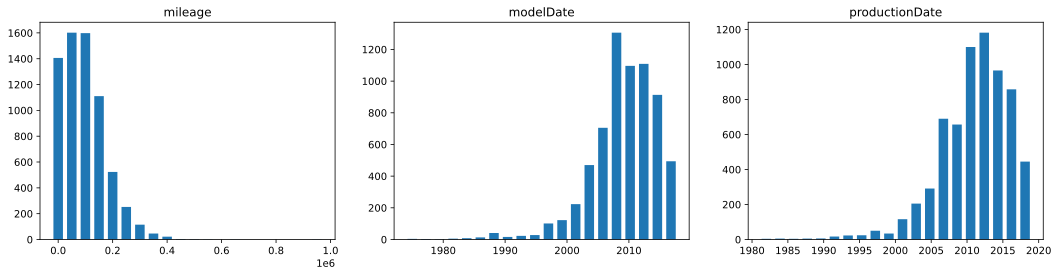

In [14]:
#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

visualize_distributions({
    'mileage': train['mileage'].dropna(),
    'modelDate': train['modelDate'].dropna(),
    'productionDate': train['productionDate'].dropna()
})

Итого:
* CatBoost сможет работать с признаками и в таком виде, но для нейросети нужны нормированные данные.

In [15]:
#import sys
#!{sys.executable} -m pip install pandas-profiling

In [19]:
# используем модуль для быстрого первичного анализа данных
#import pandas_profiling
#pandas_profiling.ProfileReport(data)

Краткий итог: в тренировочной выборке 6682 объявлений, в тестовой - 1671. Всего данных - 8353 объявлений. Имеется 23 признака. Из числовых признаков у нас: mileage, modelDate, numberOfDoors, productionDate. Остальные - типа Object. Пропуски в признаках Владельцы и Владение. Также добавился признак sample для обозначения принадлежности данных и последующего разделения

# PreProc Tabular Data

In [20]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


**bodyType**

In [21]:
data['bodyType'] = data['bodyType'].astype(str).apply(
    lambda x: None if x.strip() == '' else x)
data['bodyType'] = data.bodyType.apply(lambda x: x.split(' ')[0].lower())

<AxesSubplot:>

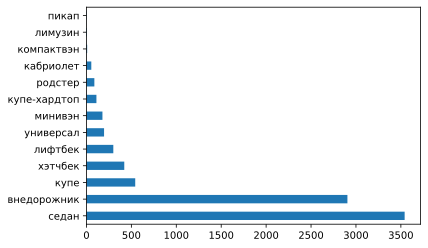

In [22]:
#посмотрим на распределение
data.bodyType.value_counts().plot.barh() 

**color**

<AxesSubplot:>

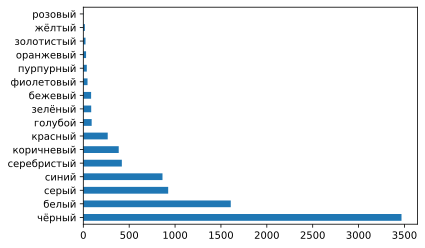

In [23]:
data.color.value_counts().plot.barh()

**fuelType**

In [24]:
data.fuelType.value_counts() #категориальный признак

бензин     6018
дизель     2315
гибрид       14
электро       6
Name: fuelType, dtype: int64

<AxesSubplot:xlabel='fuelType', ylabel='count'>

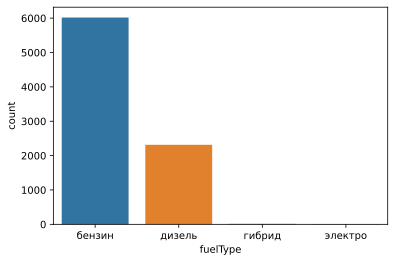

In [25]:
sns.countplot(x = 'fuelType', data = data)

**engineDisplacement**

In [26]:
data.engineDisplacement.value_counts()

2.0 LTR          2430
3.0 LTR          2349
1.8 LTR           411
1.6 LTR           410
4.4 LTR           329
5.5 LTR           268
3.5 LTR           250
2.5 LTR           248
2.1 LTR           221
4.0 LTR           153
4.7 LTR           137
2.8 LTR           106
1.4 LTR           106
4.2 LTR           103
5.0 LTR            74
1.5 LTR            73
3.2 LTR            60
2.2 LTR            58
4.8 LTR            57
2.9 LTR            50
3.1 LTR            44
2.4 LTR            44
6.2 LTR            40
6.0 LTR            37
5.4 LTR            33
1.2 LTR            33
1.3 LTR            32
2.7 LTR            24
4.1 LTR            23
3.6 LTR            23
1.7 LTR            15
3.7 LTR            14
2.3 LTR            14
5.2 LTR            13
5.9 LTR            11
2.6 LTR             9
undefined LTR       6
0.7 LTR             6
4.6 LTR             5
6.6 LTR             5
1.9 LTR             5
5.8 LTR             5
3.4 LTR             4
4.3 LTR             4
6.3 LTR             3
3.8 LTR   

<AxesSubplot:xlabel='engineDisplacement', ylabel='count'>

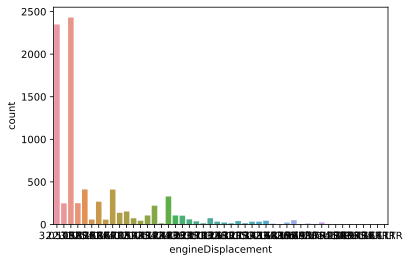

In [27]:
sns.countplot(x = 'engineDisplacement', data = data)

**enginePower**

In [28]:
data.enginePower.unique()

array(['220 N12', '313 N12', '218 N12', '136 N12', '190 N12', '340 N12',
       '245 N12', '316 N12', '170 N12', '160 N12', '231 N12', '388 N12',
       '180 N12', '367 N12', '115 N12', '184 N12', '177 N12', '455 N12',
       '422 N12', '163 N12', '249 N12', '272 N12', '224 N12', '122 N12',
       '557 N12', '333 N12', '306 N12', '156 N12', '150 N12', '264 N12',
       '450 N12', '555 N12', '407 N12', '130 N12', '400 N12', '204 N12',
       '469 N12', '192 N12', '210 N12', '211 N12', '239 N12', '200 N12',
       '350 N12', '420 N12', '300 N12', '381 N12', '265 N12', '258 N12',
       '390 N12', '197 N12', '120 N12', '544 N12', '193 N12', '235 N12',
       '233 N12', '394 N12', '355 N12', '421 N12', '320 N12', '585 N12',
       '105 N12', '280 N12', '194 N12', '132 N12', '639 N12', '250 N12',
       '335 N12', '510 N12', '116 N12', '360 N12', '238 N12', '225 N12',
       '625 N12', '571 N12', '507 N12', '286 N12', '372 N12', '575 N12',
       '408 N12', '310 N12', '354 N12', '255 N12', 

In [29]:
    #предобработаем "enginePower"
data['enginePower'] = data['enginePower'].apply(lambda x: x[:3])
data['enginePower'] = data['enginePower'].replace('7 N','7').astype('int')

<bound method Axes.barh of <AxesSubplot:>>

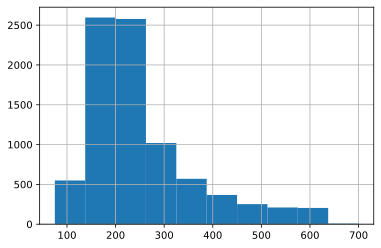

In [30]:
data.enginePower.hist().barh

**mileage**

<AxesSubplot:>

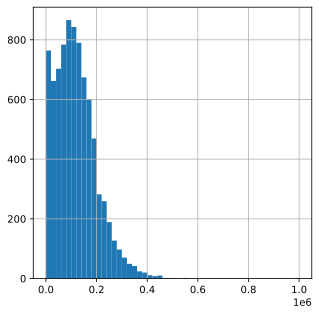

In [31]:
data['mileage'].hist(figsize=(5,5), bins=50)

добавим потом к числовым признакам и применим нормализацию

**modelDate**

AxesSubplot(0.125,0.125;0.775x0.755)


count    8353.000000
mean     2010.103556
std         5.436914
min      1971.000000
25%      2007.000000
50%      2011.000000
75%      2014.000000
max      2019.000000
Name: modelDate, dtype: float64

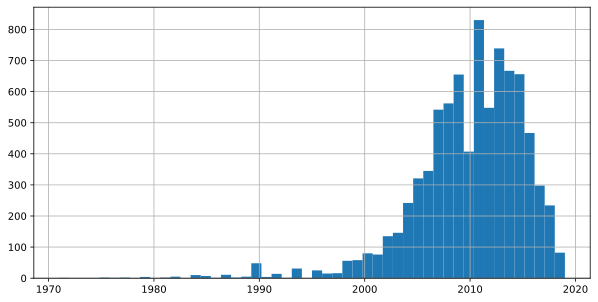

In [32]:
print(data['modelDate'].hist(figsize=(10,5), bins=50))
data['modelDate'].describe()

AxesSubplot(0.125,0.125;0.775x0.755)


count    8353.000000
mean     2012.010775
std         5.107314
min      1982.000000
25%      2009.000000
50%      2013.000000
75%      2016.000000
max      2020.000000
Name: productionDate, dtype: float64

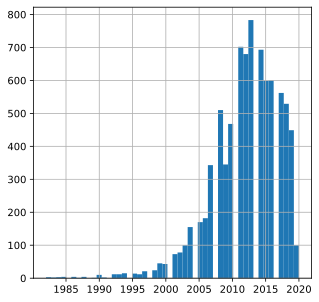

In [33]:
print(data['productionDate'].hist(figsize=(5,5), bins=50))
data['productionDate'].describe()

In [34]:
#создадим новые признаки на основе существующих: возраст модели
data['model_age'] = 2021 - data.modelDate

In [35]:
#cгенерируем признак - километраж за год
data['mile_per_year'] = data['mileage'] / data['model_age']

**numberOfDoors**

<AxesSubplot:xlabel='numberOfDoors', ylabel='count'>

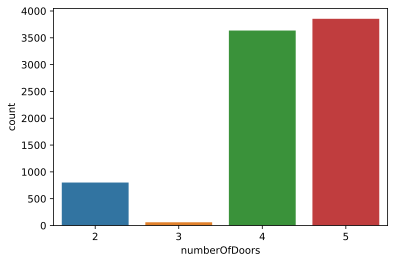

In [36]:
sns.countplot(x = 'numberOfDoors', data = data)

отнесем к категориальным

**vehicleTransmission**

<AxesSubplot:xlabel='vehicleTransmission', ylabel='count'>

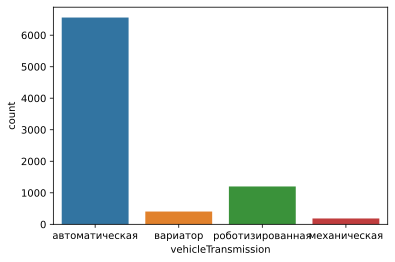

In [37]:
sns.countplot(x = 'vehicleTransmission', data = data)

категориальный признак

**Владельцы**

In [38]:
data['Владельцы'].value_counts()

3 или более    3311
1 владелец     2526
2 владельца    2515
Name: Владельцы, dtype: int64

In [39]:
# преобразуем данные, оставим только числовое значение
data['Владельцы'].fillna('3 или более', inplace=True)
data['Владельцы'] = data['Владельцы'].apply(
    lambda x: int(x[0])).astype('int32')

<AxesSubplot:xlabel='Владельцы', ylabel='count'>

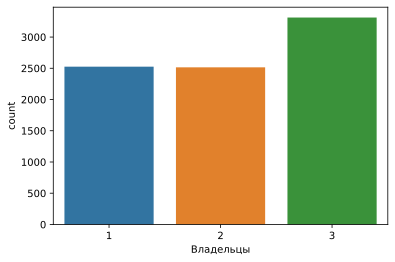

In [40]:
sns.countplot(x = 'Владельцы', data = data)

In [41]:
data.Владение.isna().sum()  #5418 пропусков из 8353 значений - это большая часть. Не вижу смысла его оставлять.

5418

**model_info**

In [42]:
data.model_info.value_counts() #относим к категориальным

5ER         776
3ER         578
X5          501
E_KLASSE    490
A6          433
           ... 
W201          1
Z1            1
X3_M          1
CITAN         1
Z8            1
Name: model_info, Length: 122, dtype: int64

**ПТС**

<AxesSubplot:xlabel='ПТС', ylabel='count'>

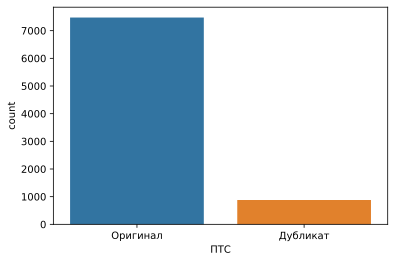

In [43]:
sns.countplot(x = 'ПТС', data = data)

**Привод**

<AxesSubplot:xlabel='Привод', ylabel='count'>

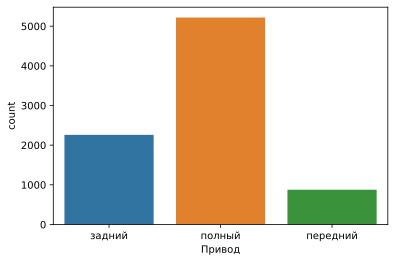

In [44]:
#посмотрим на распределение
sns.countplot(x = 'Привод', data = data)

Левый     8351
Правый       2
Name: Руль, dtype: int64

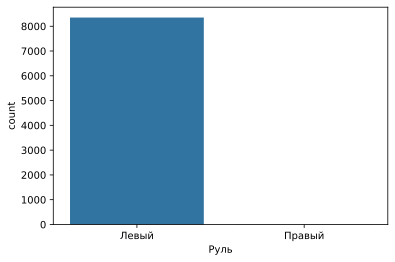

In [45]:
sns.countplot(x = 'Руль', data = data)
data.Руль.value_counts()

ПТС, Привод и Руль относим к категориальным

**name**

In [46]:
data.name.head(10)

0                 300 3.0 AT (220 л.с.)
1    640d xDrive 3.0d AT (313 л.с.) 4WD
2           325xi 2.5 AT (218 л.с.) 4WD
3                318i 2.0 AT (136 л.с.)
4    520d xDrive 2.0d AT (190 л.с.) 4WD
5     540i xDrive 3.0 AT (340 л.с.) 4WD
6                3.0d AT (245 л.с.) 4WD
7                 350 3.5 AT (316 л.с.)
8                    1.8 CVT (170 л.с.)
9                    1.8 CVT (160 л.с.)
Name: name, dtype: object

Признак 'name' содержит данные, которые уже есть в других столбцах.Сократим размерность, выделив наличие xDrive в качестве отдельного признака, а признак name удалим

In [47]:
#сгенерируем новый признак:
data['name_xDrive'] = data['name'].apply(lambda x: 1 if 'xDrive' in x else 0)

**Посмотрим на распределение целевой переменной:**

C:\Users\babaina_mv\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\babaina_mv\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


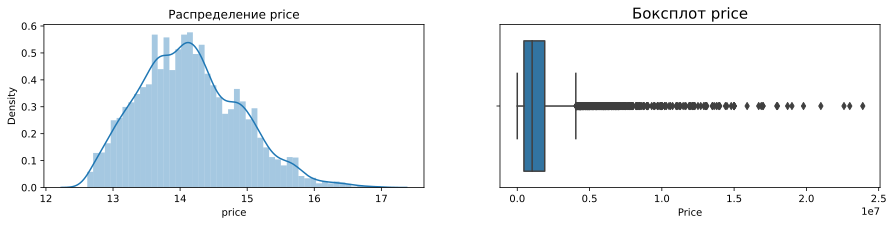

count    8.353000e+03
mean     1.519804e+06
std      1.873130e+06
min      0.000000e+00
25%      4.600000e+05
50%      1.030000e+06
75%      1.900000e+06
max      2.390000e+07
Name: price, dtype: float64

In [48]:
plt.figure(figsize=(15, 3))
plt.subplot(1,2,1)
plt.title(f"Распределение {'price'}")
sns.distplot(np.log(data[data['sample'] == 1]['price']), bins=50)

plt.subplot(1,2,2)
sns.boxplot(data['price'])
plt.xlabel('Price')
plt.title(f"Боксплот {'price'}", fontsize=15)
plt.show()
data.price.describe()

Выбросы не будем удалять, а в дальнейшем прологарифмируем их

C:\Users\babaina_mv\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\babaina_mv\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


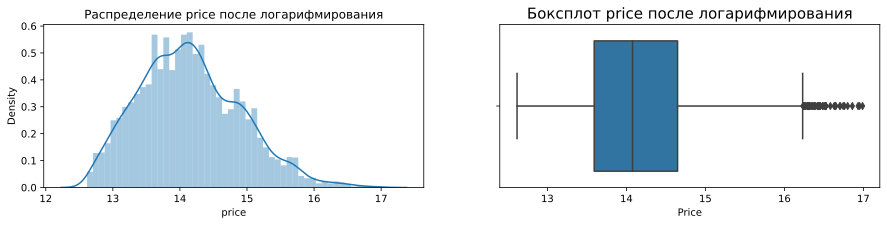

In [49]:
plt.figure(figsize=(15, 3))
plt.subplot(1,2,1)
plt.title(f"Распределение {'price'} после логарифмирования")
sns.distplot(np.log(data[data['sample'] == 1]['price']), bins=50)

plt.subplot(1,2,2)
sns.boxplot(np.log(data[data['sample'] == 1]['price']))
plt.xlabel('Price')
plt.title('Боксплот price после логарифмирования', fontsize=15)
plt.show()

C:\Users\babaina_mv\Anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


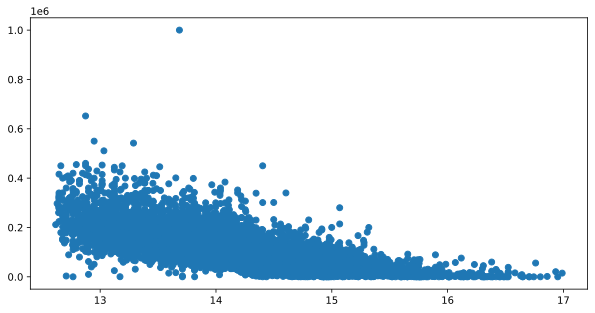

In [50]:
#Посмотрим на распределение зависимости цены от километража
plt.figure(figsize=(10, 5))
plt.scatter(np.log(data.price), data.mileage)

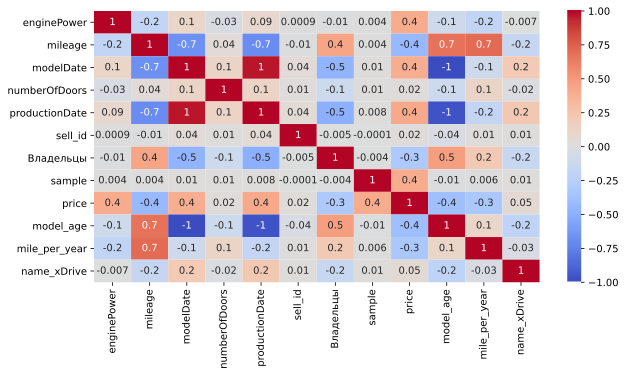

In [51]:
# корреляция

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = sns.heatmap(data.corr(),fmt='.1g',
                 annot=True, cmap='coolwarm')

видим большую корреляцию между:

model_age and modelDate

model_age and productionDate

modelDate|productionDate and mileage

Далее удалим либо modelDate или productionDate

In [52]:
data.head(3)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,sample,price,model_age,mile_per_year,name_xDrive
0,универсал,MERCEDES,чёрный,Всем привет!\n\nПродам эксклюзивный проект 124...,3.0 LTR,220,бензин,350000,1984,W124,300 3.0 AT (220 л.с.),5,1991,1099427284,WAGON_5_DOORS AUTOMATIC 3.0,автоматическая,3,6 лет и 3 месяца,Оригинал,задний,Левый,0,0.0,37,9459.459459,0
1,купе,BMW,белый,Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...,3.0 LTR,313,дизель,15000,2011,6ER,640d xDrive 3.0d AT (313 л.с.) 4WD,2,2013,1096405886,COUPE AUTOMATIC 3.0,автоматическая,1,6 лет и 6 месяцев,Оригинал,полный,Левый,0,0.0,10,1500.000000,1
2,купе,BMW,пурпурный,"Машина тут продаётся не в первый раз, НО! Толь...",2.5 LTR,218,бензин,166600,2005,3ER,325xi 2.5 AT (218 л.с.) 4WD,2,2008,1100195294,COUPE AUTOMATIC 2.5,автоматическая,3,NaN,Оригинал,полный,Левый,0,0.0,16,10412.500000,0


In [53]:
#используем все текстовые признаки как категориальные без предобработки
categorical_features = ['bodyType', 'brand', 'color', 'engineDisplacement', 'fuelType', 'model_info', 
  'numberOfDoors', 'vehicleTransmission', 'Владельцы', 'ПТС', 'Привод', 'Руль', 'name_xDrive']

#используем все числовые признаки
numerical_features = ['mileage', 'productionDate','model_age','enginePower', 'mile_per_year']

In [139]:
import category_encoders as ce

In [55]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''

    df_output = df_input.copy()

    # ################### 1. Предобработка ##############################################################
    # убираем не нужные для модели признаки
    df_output.drop(['description', 'sell_id', 'vehicleConfiguration',
                   'Владение', 'name', 'modelDate'], axis=1, inplace=True)

    # ################### Numerical Features ##############################################################
    # Далее заполняем пропуски
    for column in numerical_features:
        df_output[column].fillna(df_output[column].median(), inplace=True)


    ############################### Log ####################################################################
    # П. В нейросеть желательно подавать данные с распределением, близким к нормальному,
    # поэтому от некоторых числовых признаков имеет смысл перед нормализацией взять логарифм.Опыт показал,что 
#     метрика ухудшается
#     df_output['productionDate'] = np.log(df_output['productionDate'])
#     df_output['model_age'] = np.log(df_output['model_age'])

    # П Нормализация данных
    # scaler = MinMaxScaler()
    scaler = RobustScaler()  # применим именно эту стандартизацию,тк она устойчива к выбросам
    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:, 0]

    # ################### Categorical Features ##############################################################
    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes

    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(
        df_output, columns=categorical_features, dummy_na=False)
#       df_output = ce.HelmertEncoder(df_output, cols=categorical_features)
        
    return df_output

In [56]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)
df_preproc.sample(10)

,enginePower,mileage,productionDate,sample,price,model_age,mile_per_year,bodyType_0,bodyType_1,bodyType_2,bodyType_3,bodyType_4,bodyType_5,bodyType_6,bodyType_7,bodyType_8,bodyType_9,bodyType_10,bodyType_11,bodyType_12,brand_0,brand_1,brand_2,color_0,color_1,color_2,color_3,color_4,color_5,color_6,color_7,color_8,color_9,color_10,color_11,color_12,color_13,color_14,color_15,engineDisplacement_0,engineDisplacement_1,engineDisplacement_2,engineDisplacement_3,engineDisplacement_4,engineDisplacement_5,engineDisplacement_6,engineDisplacement_7,engineDisplacement_8,engineDisplacement_9,engineDisplacement_10,engineDisplacement_11,engineDisplacement_12,engineDisplacement_13,engineDisplacement_14,engineDisplacement_15,engineDisplacement_16,engineDisplacement_17,engineDisplacement_18,engineDisplacement_19,engineDisplacement_20,engineDisplacement_21,engineDisplacement_22,engineDisplacement_23,engineDisplacement_24,engineDisplacement_25,engineDisplacement_26,engineDisplacement_27,engineDisplacement_28,engineDisplacement_29,engineDisplacement_30,engineDisplacement_31,engineDisplacement_32,engineDisplacement_33,engineDisplacement_34,engineDisplacement_35,engineDisplacement_36,engineDisplacement_37,engineDisplacement_38,engineDisplacement_39,engineDisplacement_40,engineDisplacement_41,engineDisplacement_42,engineDisplacement_43,engineDisplacement_44,engineDisplacement_45,engineDisplacement_46,engineDisplacement_47,fuelType_0,fuelType_1,fuelType_2,fuelType_3,model_info_0,model_info_1,model_info_2,model_info_3,model_info_4,model_info_5,model_info_6,model_info_7,model_info_8,model_info_9,model_info_10,model_info_11,model_info_12,model_info_13,model_info_14,model_info_15,model_info_16,model_info_17,model_info_18,model_info_19,model_info_20,model_info_21,model_info_22,model_info_23,model_info_24,model_info_25,model_info_26,model_info_27,model_info_28,model_info_29,model_info_30,model_info_31,model_info_32,model_info_33,model_info_34,model_info_35,model_info_36,model_info_37,model_info_38,model_info_39,model_info_40,model_info_41,model_info_42,model_info_43,model_info_44,model_info_45,model_info_46,model_info_47,model_info_48,model_info_49,model_info_50,model_info_51,model_info_52,model_info_53,model_info_54,model_info_55,model_info_56,model_info_57,model_info_58,model_info_59,model_info_60,model_info_61,model_info_62,model_info_63,model_info_64,model_info_65,model_info_66,model_info_67,model_info_68,model_info_69,model_info_70,model_info_71,model_info_72,model_info_73,model_info_74,model_info_75,model_info_76,model_info_77,model_info_78,model_info_79,model_info_80,model_info_81,model_info_82,model_info_83,model_info_84,model_info_85,model_info_86,model_info_87,model_info_88,model_info_89,model_info_90,model_info_91,model_info_92,model_info_93,model_info_94,model_info_95,model_info_96,model_info_97,model_info_98,model_info_99,model_info_100,model_info_101,model_info_102,model_info_103,model_info_104,model_info_105,model_info_106,model_info_107,model_info_108,model_info_109,model_info_110,model_info_111,model_info_112,model_info_113,model_info_114,model_info_115,model_info_116,model_info_117,model_info_118,model_info_119,model_info_120,model_info_121,numberOfDoors_0,numberOfDoors_1,numberOfDoors_2,numberOfDoors_3,vehicleTransmission_0,vehicleTransmission_1,vehicleTransmission_2,vehicleTransmission_3,Владельцы_0,Владельцы_1,Владельцы_2,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2,Руль_0,Руль_1,name_xDrive_0,name_xDrive_1
7399,0.114754,-0.031380,0.285714,1,1590000.0,-0.428571,0.684332,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,1,1,0,0,1
4273,0.114754,-0.606317,0.42

In [57]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Columns: 233 entries, enginePower to name_xDrive_1
dtypes: float64(6), int64(1), uint8(226)
memory usage: 2.2 MB


## Split data

In [58]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [59]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1671 entries, 0 to 1670
Columns: 232 entries, enginePower to name_xDrive_1
dtypes: float64(6), uint8(226)
memory usage: 460.2 KB


# Model 2: CatBoostRegressor

In [60]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [61]:
model = CatBoostRegressor(iterations = 5000,
#                           depth=10,
#                           learning_rate = 0.5,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          #task_type='GPU',
                         )
model.fit(X_train, np.log(y_train),   #П применила логарифм
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=100,
         use_best_model=True,
#          plot=True
         )

Learning rate set to 0.023474
0:	learn: 0.0418660	test: 0.0419215	best: 0.0419215 (0)	total: 179ms	remaining: 14m 55s
100:	learn: 0.0131105	test: 0.0128850	best: 0.0128850 (100)	total: 470ms	remaining: 22.8s
200:	learn: 0.0104734	test: 0.0102620	best: 0.0102620 (200)	total: 744ms	remaining: 17.8s
300:	learn: 0.0097876	test: 0.0096830	best: 0.0096830 (300)	total: 1.02s	remaining: 16s
400:	learn: 0.0093968	test: 0.0093900	best: 0.0093900 (400)	total: 1.3s	remaining: 14.9s
500:	learn: 0.0090698	test: 0.0091838	best: 0.0091838 (500)	total: 1.57s	remaining: 14.2s
600:	learn: 0.0087256	test: 0.0089544	best: 0.0089544 (600)	total: 1.85s	remaining: 13.6s
700:	learn: 0.0084258	test: 0.0087523	best: 0.0087523 (700)	total: 2.13s	remaining: 13s
800:	learn: 0.0082323	test: 0.0086251	best: 0.0086251 (800)	total: 2.4s	remaining: 12.6s
900:	learn: 0.0080155	test: 0.0084880	best: 0.0084880 (900)	total: 2.67s	remaining: 12.1s
1000:	learn: 0.0078219	test: 0.0083711	best: 0.0083711 (1000)	total: 2.94s	rem

In [62]:
test_predict_catboost = np.exp(model.predict(X_test))
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

TEST mape: 11.15%


### Submission

In [63]:
sub_predict_catboost = np.exp(model.predict(X_sub))
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission.csv', index=False)

# Model 3: Tabular NN

Построим обычную сеть:

In [64]:
X_train.head(5)

,enginePower,mileage,productionDate,model_age,mile_per_year,bodyType_0,bodyType_1,bodyType_2,bodyType_3,bodyType_4,bodyType_5,bodyType_6,bodyType_7,bodyType_8,bodyType_9,bodyType_10,bodyType_11,bodyType_12,brand_0,brand_1,brand_2,color_0,color_1,color_2,color_3,color_4,color_5,color_6,color_7,color_8,color_9,color_10,color_11,color_12,color_13,color_14,color_15,engineDisplacement_0,engineDisplacement_1,engineDisplacement_2,engineDisplacement_3,engineDisplacement_4,engineDisplacement_5,engineDisplacement_6,engineDisplacement_7,engineDisplacement_8,engineDisplacement_9,engineDisplacement_10,engineDisplacement_11,engineDisplacement_12,engineDisplacement_13,engineDisplacement_14,engineDisplacement_15,engineDisplacement_16,engineDisplacement_17,engineDisplacement_18,engineDisplacement_19,engineDisplacement_20,engineDisplacement_21,engineDisplacement_22,engineDisplacement_23,engineDisplacement_24,engineDisplacement_25,engineDisplacement_26,engineDisplacement_27,engineDisplacement_28,engineDisplacement_29,engineDisplacement_30,engineDisplacement_31,engineDisplacement_32,engineDisplacement_33,engineDisplacement_34,engineDisplacement_35,engineDisplacement_36,engineDisplacement_37,engineDisplacement_38,engineDisplacement_39,engineDisplacement_40,engineDisplacement_41,engineDisplacement_42,engineDisplacement_43,engineDisplacement_44,engineDisplacement_45,engineDisplacement_46,engineDisplacement_47,fuelType_0,fuelType_1,fuelType_2,fuelType_3,model_info_0,model_info_1,model_info_2,model_info_3,model_info_4,model_info_5,model_info_6,model_info_7,model_info_8,model_info_9,model_info_10,model_info_11,model_info_12,model_info_13,model_info_14,model_info_15,model_info_16,model_info_17,model_info_18,model_info_19,model_info_20,model_info_21,model_info_22,model_info_23,model_info_24,model_info_25,model_info_26,model_info_27,model_info_28,model_info_29,model_info_30,model_info_31,model_info_32,model_info_33,model_info_34,model_info_35,model_info_36,model_info_37,model_info_38,model_info_39,model_info_40,model_info_41,model_info_42,model_info_43,model_info_44,model_info_45,model_info_46,model_info_47,model_info_48,model_info_49,model_info_50,model_info_51,model_info_52,model_info_53,model_info_54,model_info_55,model_info_56,model_info_57,model_info_58,model_info_59,model_info_60,model_info_61,model_info_62,model_info_63,model_info_64,model_info_65,model_info_66,model_info_67,model_info_68,model_info_69,model_info_70,model_info_71,model_info_72,model_info_73,model_info_74,model_info_75,model_info_76,model_info_77,model_info_78,model_info_79,model_info_80,model_info_81,model_info_82,model_info_83,model_info_84,model_info_85,model_info_86,model_info_87,model_info_88,model_info_89,model_info_90,model_info_91,model_info_92,model_info_93,model_info_94,model_info_95,model_info_96,model_info_97,model_info_98,model_info_99,model_info_100,model_info_101,model_info_102,model_info_103,model_info_104,model_info_105,model_info_106,model_info_107,model_info_108,model_info_109,model_info_110,model_info_111,model_info_112,model_info_113,model_info_114,model_info_115,model_info_116,model_info_117,model_info_118,model_info_119,model_info_120,model_info_121,numberOfDoors_0,numberOfDoors_1,numberOfDoors_2,numberOfDoors_3,vehicleTransmission_0,vehicleTransmission_1,vehicleTransmission_2,vehicleTransmission_3,Владельцы_0,Владельцы_1,Владельцы_2,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2,Руль_0,Руль_1,name_xDrive_0,name_xDrive_1
7320,2.565574,0.367366,-0.285714,0.428571,0.151863,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,1,0,0,1,0,1,0
8037,0.114754,-0.829411,0.714286,-0.714286,-0.892551,1

## Simple Dense NN

In [65]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="sigmoid")) #поменяла relu -> sigmoid
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dense(256, activation="relu")) #добавили допонительный полносвязный слой
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

In [66]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               118784    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 316,161
Trainable params: 316,161
Non-trainable params: 0
__________________________________________________

In [67]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [68]:
checkpoint = ModelCheckpoint(
    '../working/best_model.hdf5', monitor='val_MAPE',
                    save_best_only=True, verbose=0, mode='min')
earlystop = EarlyStopping(
    monitor='val_MAPE', patience=50, restore_best_weights=True,) 
callbacks_list = [checkpoint, earlystop]

### Fit

In [69]:
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=350, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

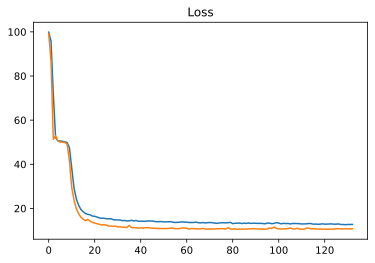

In [70]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [73]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_1.hdf5')

In [74]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 10.52%


10.52 c sigmoid+model.add(L.Dense(256, activation="relu"))

In [75]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv('nn1_submission.csv', index=False)

# Model 4: NLP + Multiple Inputs

In [76]:
 data['description']

0       Всем привет!\n\nПродам эксклюзивный проект 124...
1       Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...
2       Машина тут продаётся не в первый раз, НО! Толь...
3       Автомобиль в отличном состоянии, весь в родной...
4       Немка! с бесключивым доступом и камерой заднег...
                              ...                        
8348    Продаётся любимый автомобиль! За годы эксплуат...
8349    Куплена у официального дилера в 2017 г. \n\nТр...
8350    Торг на месте. Все работает. Сборка немецкая. ...
8351    Автомобиль в отличном состоянии.\n3-из Авто в ...
8352    Удлиненный заводской Pullman на базе W140 (воо...
Name: description, Length: 8353, dtype: object

In [77]:
#P
morph = pymorphy2.MorphAnalyzer()
data_NLP = data.copy()

In [78]:
#P 
#создадим функцию. в которой будет и лемматизация и очистка текста
patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"


def lemmatize(doc):
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        token = token.strip()
        token = morph.normal_forms(token)[0]
        tokens.append(token)
    return ' '.join(tokens)

In [79]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\babaina_mv\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [80]:
#P
data_NLP['description'] = data_NLP.apply(
    lambda data_NLP: lemmatize(data_NLP.description), axis=1)

In [81]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [82]:
# split данных
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

### Tokenizer

In [83]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data_NLP['description'])

Wall time: 970 ms


In [84]:
tokenize.word_index

{'•': 1,
 'в': 2,
 'и': 3,
 'с': 4,
 'автомобиль': 5,
 'на': 6,
 'не': 7,
 'по': 8,
 'система': 9,
 'всё': 10,
 'пробег': 11,
 'задний': 12,
 'салон': 13,
 'сидение': 14,
 'год': 15,
 'состояние': 16,
 'для': 17,
 'передний': 18,
 'машина': 19,
 'от': 20,
 'до': 21,
 'при': 22,
 'диск': 23,
 'у': 24,
 'комплект': 25,
 'дилер': 26,
 'новый': 27,
 'официальный': 28,
 'без': 29,
 'ваш': 30,
 'кредит': 31,
 'вы': 32,
 'фара': 33,
 'авто': 34,
 'быть': 35,
 'руль': 36,
 'пакет': 37,
 'колесо': 38,
 'безопасность': 39,
 'комплектация': 40,
 'за': 41,
 'гарантия': 42,
 'птс': 43,
 'обмен': 44,
 'контроль': 45,
 'то': 46,
 'зеркало': 47,
 'проверка': 48,
 'из': 49,
 'покупка': 50,
 'весь': 51,
 'два': 52,
 'продажа': 53,
 'водитель': 54,
 'более': 55,
 'полный': 56,
 'есть': 57,
 'шина': 58,
 'км': 59,
 'датчик': 60,
 'отличный': 61,
 'пассажир': 62,
 'двигатель': 63,
 'так': 64,
 'резина': 65,
 'мы': 66,
 'условие': 67,
 'владелец': 68,
 'только': 69,
 'ключ': 70,
 'один': 71,
 'хороший': 72,

Благодаря получившемуся словарю мы сможем произвести дальнейшую векторизацию нашего текста. 

In [85]:
# % % time
text_train_sequences = sequence.pad_sequences(
    tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(
    tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(
    tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape,
      text_test_sequences.shape, text_sub_sequences.shape, )

(5679, 256) (1003, 256) (1671, 256)


In [86]:
# вот так теперь выглядит наш текст
print(text_train.iloc[6])
print(text_train_sequences[6])

.

• Автомобиль проверен по 110 пунктам
• Автокредит по специальной ставке от 13,7%

Ауди Центр Север, официальный дилер Audi, входящий в группу компаний РОЛЬФ и являющийся одним из крупнейших дилеров в Европе, предлагает Вам ряд услуг по покупке и продаже автомобилей с пробегом.

На протяжении многих лет наш дилерский центр является лидером по продаже автомобилей с пробегом среди всех дилеров Audi в России и предоставляет клиентам самый большой выбор автомобилей с пробегом Audi и других марок.
Каждый автомобиль проходит тщательную диагностику и подготовку, и гарантировано находится в отличном состоянии.
Чтобы убедиться в правильном выборе, у Вас есть возможность пройти тест-драйв ― ознакомительную поездку на интересующем автомобиле.
Вы сможете ознакомиться с автомобилем не выходя из дома – наш менеджер проведет online презентацию и в видеозвонке покажет выбранный автомобиль.
Также Ауди Центр Север представляет уникальное предложение по кредитованию автомобилей с пробегом на индивидуал

### RNN NLP

Теперь строим сеть для обработки текста. Для простоты в примере используем LSTM:

In [87]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))

# model_nlp.add(L.BatchNormalization(axis=1)) #добавим BatchNormalization

model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.Dense(64, activation="sigmoid")) #добавим полносвязный слой
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

### MLP

Эта сеть построена «без головы». Добавим ещё одну сеть — созданную нами ранее для табличных данных:

In [88]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="sigmoid"))
# model_mlp.add(L.BatchNormalization(axis=1)) #добавим BatchNormalization
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dense(256, activation="relu")) #добавим еще один полносвязный слой
model_mlp.add(L.Dropout(0.5))

### Multiple Inputs NN

Осталось объединить их в Multi-Input сеть, то есть сеть, которая позволяет брать на вход несколько сетей и объединять их результаты. За объединение отвечает слой L.concatenate:

In [89]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [90]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 256)     3673856     seq_description[0][0]            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256, 256)     525312      embedding[0][0]                  
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 256, 256)     0           lstm[0][0]                       
_______________________________________________________________________________________

### Fit

In [91]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [92]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor='val_MAPE',
                            save_best_only=True, verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [93]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=350, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/350
12/12 [==============================] - 53s 4s/step - loss: 99.6976 - MAPE: 99.6976 - val_loss: 96.6363 - val_MAPE: 96.6363
Epoch 2/350
12/12 [==============================] - 65s 5s/step - loss: 77.1704 - MAPE: 77.1704 - val_loss: 57.7561 - val_MAPE: 57.7561
Epoch 3/350
12/12 [==============================] - 73s 6s/step - loss: 54.6453 - MAPE: 54.6453 - val_loss: 53.8546 - val_MAPE: 53.8546
Epoch 4/350
12/12 [==============================] - 83s 7s/step - loss: 50.4520 - MAPE: 50.4520 - val_loss: 49.0841 - val_MAPE: 49.0841
Epoch 5/350
12/12 [==============================] - 94s 8s/step - loss: 46.2813 - MAPE: 46.2813 - val_loss: 39.2547 - val_MAPE: 39.2547
Epoch 6/350
12/12 [==============================] - 97s 8s/step - loss: 36.0671 - MAPE: 36.0671 - val_loss: 29.8126 - val_MAPE: 29.8126
Epoch 7/350
12/12 [==============================] - 97s 8s/step - loss: 28.8804 - MAPE: 28.8804 - val_loss: 23.4109 - val_MAPE: 23.4109
Epoch 8/350
12/12 [======================

12/12 [==============================] - 98s 8s/step - loss: 12.5348 - MAPE: 12.5348 - val_loss: 11.0137 - val_MAPE: 11.0137
Epoch 61/350
12/12 [==============================] - 97s 8s/step - loss: 12.4557 - MAPE: 12.4557 - val_loss: 11.2532 - val_MAPE: 11.2532
Epoch 62/350
12/12 [==============================] - 99s 8s/step - loss: 12.6205 - MAPE: 12.6205 - val_loss: 11.0021 - val_MAPE: 11.0021
Epoch 63/350
12/12 [==============================] - 99s 8s/step - loss: 12.7765 - MAPE: 12.7765 - val_loss: 11.1088 - val_MAPE: 11.1088
Epoch 64/350
12/12 [==============================] - 100s 8s/step - loss: 12.7938 - MAPE: 12.7938 - val_loss: 10.7905 - val_MAPE: 10.7905
Epoch 65/350
12/12 [==============================] - 98s 8s/step - loss: 12.4101 - MAPE: 12.4101 - val_loss: 10.8632 - val_MAPE: 10.8632
Epoch 66/350
12/12 [==============================] - 99s 8s/step - loss: 12.3334 - MAPE: 12.3334 - val_loss: 11.0014 - val_MAPE: 11.0014
Epoch 67/350
12/12 [==========================

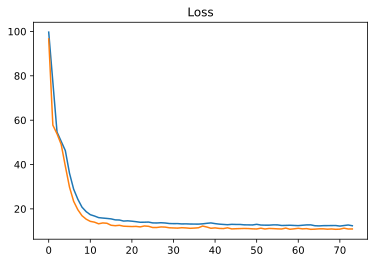

In [94]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [89]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')

In [95]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 10.79%


TEST mape: 10.88% - без обработок

TEST mape: 10.79% - с обработкой текста

In [96]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv('nn2_submission.csv', index=False)

BatchNormalization не приводило к улучшению. Добавление полносвязных слоев привело к улучшению метрики.

# Model 5: Добавляем картинки

### Data

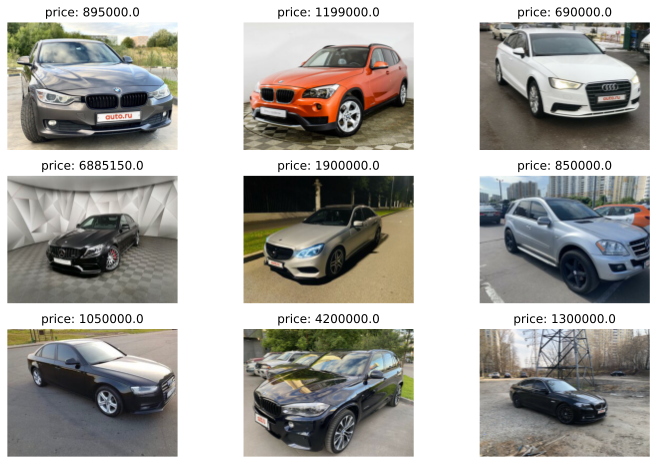

In [97]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open('img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [98]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread('img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5679, 240, 320, 3) dtype uint8
images shape (1003, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


### albumentations

Подготовим версию аугментации изображений

In [99]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)

In [100]:
AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=30, interpolation=1, border_mode=4,
                          value=None, mask_value=None, always_apply=False, p=0.5),
    albumentations.OneOf([
        albumentations.CenterCrop(height=224, width=200),
        albumentations.CenterCrop(height=200, width=224),
    ], p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(
            brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(
            brightness_limit=0.1, contrast_limit=0.1)
    ], p=0.5),
    albumentations.GaussianBlur(p=0.05),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RGBShift(p=0.5),
    albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    albumentations.Resize(240, 320)
])

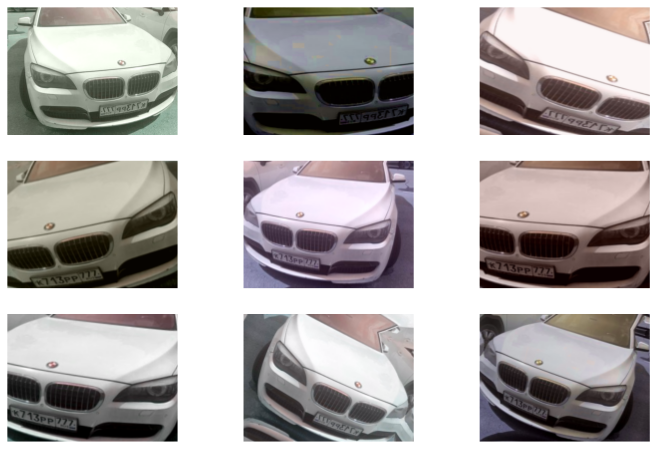

In [101]:
#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = AUGMENTATIONS(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [105]:
def make_augmentations(images):
    print('применение аугментаций', end = '')
    augmented_images = np.empty(images.shape)
    for i in range(images.shape[0]):
        if i % 200 == 0:
            print('.', end = '')
    augment_dict = AUGMENTATIONS(image = images[i])
    augmented_image = augment_dict['image']
    augmented_images[i] = augmented_image
    print('')
    return augmented_images

In [106]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data_NLP['description'])

In [107]:
def process_image(image):
    return AUGMENTATIONS(image=image.numpy())['image']


def tokenize_(descriptions):
    return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen=MAX_SEQUENCE_LENGTH)


def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]


def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image, ] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text, ] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price


def tf_process_val_dataset_element(image, table_data, text, price):
    [text, ] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price


train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.description.iloc[X_train.index], y_train
)).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.description.iloc[X_test.index], y_test
)).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.description.iloc[X_sub.index], y_sub
)).map(tf_process_val_dataset_element)

# проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__()
test_dataset.__iter__().__next__()
sub_dataset.__iter__().__next__()

((<tf.Tensor: shape=(240, 320, 3), dtype=uint8, numpy=
  array([[[130, 123, 120],
          [128, 121, 118],
          [170, 163, 160],
          ...,
          [147, 152, 153],
          [219, 228, 231],
          [201, 212, 216]],
  
         [[186, 179, 176],
          [229, 222, 219],
          [210, 203, 200],
          ...,
          [152, 157, 158],
          [220, 229, 232],
          [200, 211, 215]],
  
         [[175, 168, 165],
          [224, 217, 214],
          [214, 207, 204],
          ...,
          [157, 162, 165],
          [221, 230, 233],
          [200, 211, 215]],
  
         ...,
  
         [[127, 118, 105],
          [118, 109,  96],
          [130, 121, 108],
          ...,
          [133, 121, 115],
          [145, 132, 124],
          [174, 162, 152]],
  
         [[124, 113,  99],
          [131, 119, 107],
          [123, 111,  99],
          ...,
          [156, 147, 138],
          [153, 143, 133],
          [163, 153, 143]],
  
         [[133, 122, 10

### Строим сверточную сеть для анализа изображений без "головы"

В данной части работы проверялось несколько разных моделей из семейства EfficientNet, но решено остановиться на В3, потому что она дает наиболее надежный результат.

In [108]:
# нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights='imagenet',
                                                                       include_top=False, input_shape=(size[1], size[0], 3))

In [109]:
# Для начала, сеть, которую подгрузили,никак не обучаем. Будем обучать только верхние слои,которые мы рандомно инициализировали
efficientnet_model.trainable = True

In [110]:
# Будем работать со слоями начиная с этого момента
fine_tune_at = len(efficientnet_model.layers)//2

# Keep all other layers frozen
for layer in efficientnet_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [111]:
# проверим количество и статус слоев
print(len(efficientnet_model.layers))

for layer in efficientnet_model.layers:
    print(layer, layer.trainable)

384
<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x0000021E809E28E0> False
<tensorflow.python.keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x0000021E809E2940> False
<tensorflow.python.keras.layers.preprocessing.normalization.Normalization object at 0x0000021E809E2100> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x0000021E804FA460> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000021E809FE520> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x0000021E89FD2A00> False
<tensorflow.python.keras.layers.core.Activation object at 0x0000021E809ED4C0> False
<tensorflow.python.keras.layers.convolutional.DepthwiseConv2D object at 0x0000021E80DAC340> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x0000021E80DAC070> False
<tensorflow.python.keras.layers.core.Activation object at 0x0000021E89F525B0> False
<tensorflow.python.keras

In [112]:
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

In [113]:
#строим нейросеть для анализа табличных данных
tabular_model = Sequential([
    L.Input(shape = X.shape[1]),
    L.Dense(512, activation = 'sigmoid'),  # изменим функцию активации
    L.LayerNormalization(),
    L.Dropout(0.5),
    L.Dense(256, activation = 'relu'),#добавили еще один полносвязный слой 
    L.Dense(256, activation = 'relu'),
    L.Dropout(0.5),
    ])

In [114]:
# NLP: немного изменим базовую архитектуру
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LayerNormalization(), #добавили нормализацию
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.Dense(128, activation = 'sigmoid'), #добавили полносвязный слой с функцией активации sigmoid
    L.Dropout(0.5),
    L.LSTM(64),
    L.Dropout(0.25),
    L.Dense(64),
    L.Dropout(0.25)
    ])

In [115]:
# объединяем выходы трех нейросетей
combinedInput = L.concatenate(
    [efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input,
                      tabular_model.input, nlp_model.input], outputs=head)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 320, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [116]:
optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

попробуем применить ExponentialDecay для управления learning rate

In [117]:
initial_learning_rate = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100, decay_rate=0.9)

In [118]:
checkpoint = ModelCheckpoint(
    '../working/best_model.hdf5', monitor='val_MAPE', save_best_only=True, verbose=0, mode='min')
earlystop = EarlyStopping(
    monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [119]:
history = model.fit(train_dataset.batch(30),
                    epochs=100,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

Epoch 1/100
190/190 [==============================] - 1261s 7s/step - loss: 39.6150 - MAPE: 39.6150 - val_loss: 2892.9956 - val_MAPE: 2892.9956
Epoch 2/100
190/190 [==============================] - 1339s 7s/step - loss: 18.7408 - MAPE: 18.7408 - val_loss: 15.9344 - val_MAPE: 15.9344
Epoch 3/100
190/190 [==============================] - 3646s 19s/step - loss: 17.0531 - MAPE: 17.0531 - val_loss: 13.8206 - val_MAPE: 13.8206
Epoch 4/100
190/190 [==============================] - 1510s 8s/step - loss: 16.7835 - MAPE: 16.7835 - val_loss: 13.2200 - val_MAPE: 13.2200
Epoch 5/100
190/190 [==============================] - 1526s 8s/step - loss: 15.9293 - MAPE: 15.9293 - val_loss: 12.6790 - val_MAPE: 12.6790
Epoch 6/100
190/190 [==============================] - 1531s 8s/step - loss: 15.6719 - MAPE: 15.6719 - val_loss: 12.6991 - val_MAPE: 12.6991
Epoch 7/100
190/190 [==============================] - 1438s 8s/step - loss: 15.4119 - MAPE: 15.4119 - val_loss: 12.9026 - val_MAPE: 12.9026
Epoch 8/

In [128]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [124]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')

In [125]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 10.89%


In [141]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv('nn3_submission.csv', index=False)

# Blend

In [129]:
blend_predict = (test_predict_catboost +
                 test_predict_nn1[:, 0] + test_predict_nn3[:, 0]) / 3
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 10.23%


In [142]:
blend_sub_predict = (sub_predict_catboost +
                     sub_predict_nn1[:, 0] + sub_predict_nn3[:, 0]) / 3
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False)